In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

import optuna

import warnings
warnings.filterwarnings(action = 'ignore')

## 데이터 불러오기

In [2]:
df = pd.read_csv("./dataset/my_delivery_raw.csv")
df

,Unnamed: 0,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,...,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time,created_year,created_month,created_day,created_hour,created_minute,created_second,created_dayofweek
0,0,1,1845,american,1,4,3441,4,557,1239,...,446,861,3779.0,2015,2,6,22,24,17,4
1,1,2,5477,mexican,2,1,1900,1,1400,1400,...,446,690,4024.0,2015,2,10,21,49,25,1
2,2,3,5477,indian,1,1,1900,1,1900,1900,...,446,690,1781.0,2015,1,22,20,39,28,3
3,3,3,5477,indian,1,6,6900,5,600,1800,...,446,289,3075.0,2015,2,3,21,21,45,1
4,4,3,5477,indian,1,3,3900,3,1100,1600,...,446,650,2390.0,2015,2,15,2,40,36,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196749,196749,1,2956,fast,4,3,1389,3,345,649,...,251,331,3907.0,2015,2,17,0,19,41,1
196750,196750,1,2956,fast,4,6,3010,4,405,825,...,251,915,3383.0,2015,2,13,0,1,59,4
196751,196751,1,2956,fast,4,5,1836,3,300,399,...,251,795,3008.0,2015,1,24,4,46,8,5
196752,196752,1,3630,sandwich,1,1,1175,1,535,535,...,446,384,3907.0,2015,2,1,18,18,15,6


In [3]:
df['created_year'] = df['created_year'].astype('object')
df['created_day'] = df['created_day'].astype('object')
df['created_hour'] = df['created_hour'].astype('object')
df['created_minute'] = df['created_minute'].astype('object')
df['created_second'] = df['created_second'].astype('object')
df['created_dayofweek'] = df['created_dayofweek'].astype('object')
df['created_month'] = df['created_month'].astype('object')

In [4]:
df['market_id'] = df['market_id'].astype('object')
df['store_id'] = df['store_id'].astype('object')
df['order_protocol'] = df['order_protocol'].astype('object')

In [5]:
df = df.drop('Unnamed: 0', axis = 1)

In [6]:
df

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,...,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time,created_year,created_month,created_day,created_hour,created_minute,created_second,created_dayofweek
0,1,1845,american,1,4,3441,4,557,1239,33.0,...,446,861,3779.0,2015,2,6,22,24,17,4
1,2,5477,mexican,2,1,1900,1,1400,1400,1.0,...,446,690,4024.0,2015,2,10,21,49,25,1
2,3,5477,indian,1,1,1900,1,1900,1900,1.0,...,446,690,1781.0,2015,1,22,20,39,28,3
3,3,5477,indian,1,6,6900,5,600,1800,1.0,...,446,289,3075.0,2015,2,3,21,21,45,1
4,3,5477,indian,1,3,3900,3,1100,1600,6.0,...,446,650,2390.0,2015,2,15,2,40,36,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196749,1,2956,fast,4,3,1389,3,345,649,17.0,...,251,331,3907.0,2015,2,17,0,19,41,1
196750,1,2956,fast,4,6,3010,4,405,825,12.0,...,251,915,3383.0,2015,2,13,0,1,59,4
196751,1,2956,fast,4,5,1836,3,300,399,39.0,...,251,795,3008.0,2015,1,24,4,46,8,5
196752,1,3630,sandwich,1,1,1175,1,535,535,7.0,...,446,384,3907.0,2015,2,1,18,18,15,6


배달 지역에 따라 market_id가 달라지므로 카테고리형 변수로 간주

---

## 데이터 분할
훈련 데이터와 테스트 데이터(9:1), 분할한 훈련 데이터에 대해서 검증 데이터 분할(8:2)<br>
`random_state = 42`로 고정

In [7]:
# target과 분할
target = df['delivery_time']
target

0         3779.0
1         4024.0
2         1781.0
3         3075.0
4         2390.0
           ...  
196749    3907.0
196750    3383.0
196751    3008.0
196752    3907.0
196753    2228.0
Name: delivery_time, Length: 196754, dtype: float64

In [8]:
train_df = df.drop('delivery_time', axis = 1)
train_df

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,...,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,created_year,created_month,created_day,created_hour,created_minute,created_second,created_dayofweek
0,1,1845,american,1,4,3441,4,557,1239,33.0,...,21.0,446,861,2015,2,6,22,24,17,4
1,2,5477,mexican,2,1,1900,1,1400,1400,1.0,...,2.0,446,690,2015,2,10,21,49,25,1
2,3,5477,indian,1,1,1900,1,1900,1900,1.0,...,0.0,446,690,2015,1,22,20,39,28,3
3,3,5477,indian,1,6,6900,5,600,1800,1.0,...,2.0,446,289,2015,2,3,21,21,45,1
4,3,5477,indian,1,3,3900,3,1100,1600,6.0,...,9.0,446,650,2015,2,15,2,40,36,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196749,1,2956,fast,4,3,1389,3,345,649,17.0,...,23.0,251,331,2015,2,17,0,19,41,1
196750,1,2956,fast,4,6,3010,4,405,825,12.0,...,14.0,251,915,2015,2,13,0,1,59,4
196751,1,2956,fast,4,5,1836,3,300,399,39.0,...,40.0,251,795,2015,1,24,4,46,8,5
196752,1,3630,sandwich,1,1,1175,1,535,535,7.0,...,12.0,446,384,2015,2,1,18,18,15,6


In [9]:
# 훈련 데이터와 테스트 데이터 분할
temp_train, test, temp_target, target = train_test_split(train_df, target, test_size = 0.1, random_state = 42)

In [10]:
print('전체 데이터 수(데이터, 타깃): ', len(train_df))
print('훈련 데이터 수(데이터, 타깃): ', len(temp_train), len(temp_target))
print('테스트 데이터 수(데이터, 타깃): ', len(test), len(target))

전체 데이터 수(데이터, 타깃):  196754
훈련 데이터 수(데이터, 타깃):  177078 177078
테스트 데이터 수(데이터, 타깃):  19676 19676


In [11]:
test

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,...,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,created_year,created_month,created_day,created_hour,created_minute,created_second,created_dayofweek
151712,3,4809,american,1,4,4700,3,900,1400,15.0,...,15.0,446,316,2015,1,31,2,3,2,5
74887,2,809,salad,3,1,599,1,599,599,86.0,...,152.0,251,485,2015,2,2,2,17,51,0
180768,6,1319,mexican,2,1,1025,1,975,975,24.0,...,24.0,251,481,2015,1,26,22,16,4,0
97603,2,5815,pizza,3,4,2636,4,149,1459,20.0,...,17.0,251,389,2015,1,28,22,23,43,2
53882,1,2430,breakfast,5,2,2490,2,895,1295,24.0,...,18.0,251,345,2015,1,21,20,6,54,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126696,1,2043,mediterranean,3,4,3649,4,350,1250,60.0,...,52.0,251,474,2015,1,24,1,42,35,5
169076,1,6392,convenience-store,4,3,1007,3,169,579,20.0,...,21.0,251,206,2015,2,14,5,44,44,5
163859,3,4992,cafe,1,3,2226,3,384,1006,8.0,...,14.0,446,961,2015,2,16,17,21,58,0
125641,6,2401,japanese,3,4,3935,4,650,1195,24.0,...,24.0,251,182,2015,2,7,3,2,45,5


In [12]:
target

151712    2030.0
74887     6033.0
180768    1885.0
97603     2036.0
53882     2216.0
           ...  
126696    2692.0
169076    2517.0
163859    5292.0
125641    2740.0
85653     2733.0
Name: delivery_time, Length: 19676, dtype: float64

테스트 데이터가 10%비율로 나뉜 것 확인<br>
마찬가지로 `random_state = 42`

In [13]:
# 검증 데이터와 훈련 데이터 분할
train, valid, train_target, valid_target = train_test_split(temp_train, temp_target, test_size = 0.2, random_state = 42)

In [14]:
print('훈련 데이터 수(데이터, 타깃): ', len(train), len(train_target))
print('검증 데이터 수(데이터, 타깃): ', len(valid), len(valid_target))
print('테스트 데이터 수(데이터, 타깃): ', len(test), len(target))

훈련 데이터 수(데이터, 타깃):  141662 141662
검증 데이터 수(데이터, 타깃):  35416 35416
테스트 데이터 수(데이터, 타깃):  19676 19676


훈련, 검증, 테스트 데이터가 각각 141,662개, 35,416개, 19,676개로 분할된 것을 확인가능

---

## 데이터 전처리
object column들에 대해서 one-hot encoding


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196754 entries, 0 to 196753
Data columns (total 22 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196754 non-null  object 
 1   store_id                                      196754 non-null  object 
 2   store_primary_category                        196754 non-null  object 
 3   order_protocol                                196754 non-null  object 
 4   total_items                                   196754 non-null  int64  
 5   subtotal                                      196754 non-null  int64  
 6   num_distinct_items                            196754 non-null  int64  
 7   min_item_price                                196754 non-null  int64  
 8   max_item_price                                196754 non-null  int64  
 9   total_onshift                                 19

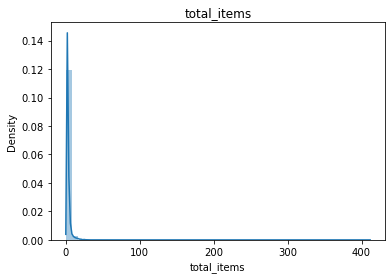

In [16]:
plt.title('total_items')
sns.distplot(df['total_items'])
plt.show()

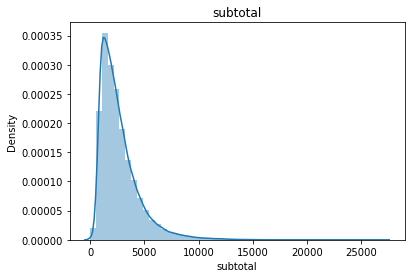

In [17]:
plt.title('subtotal')
sns.distplot(df['subtotal'])
plt.show()

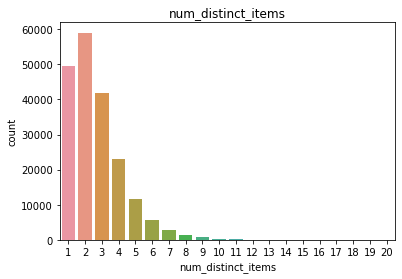

In [18]:
plt.title('num_distinct_items')
sns.countplot(df['num_distinct_items'])
plt.show()

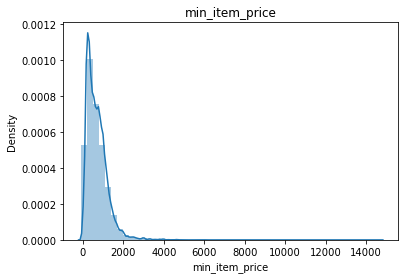

In [19]:
plt.title('min_item_price')
sns.distplot(df['min_item_price'])
plt.show()

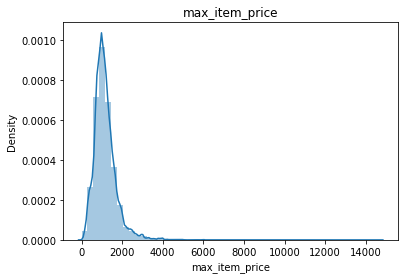

In [20]:
plt.title('max_item_price')
sns.distplot(df['max_item_price'])
plt.show()

object 칼럼에 대해서는 onehot encoding

In [21]:
object_cols = [col for col in train.columns if train[col].dtype == 'O']
numeric_cols = [col for col in train.columns if train[col].dtype != 'O']

In [22]:
print('object cols:', object_cols)
print('numeric cols:', numeric_cols)

object cols: ['market_id', 'store_id', 'store_primary_category', 'order_protocol', 'created_year', 'created_month', 'created_day', 'created_hour', 'created_minute', 'created_second', 'created_dayofweek']
numeric cols: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift', 'total_busy', 'total_outstanding_orders', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration']


In [23]:
xtrain, xvalid, xtest = train, valid, test

In [24]:
# object_cols는 one-hot encoding
ohe_xtrain = pd.get_dummies(train[object_cols])
ohe_xvalid = pd.get_dummies(valid[object_cols])
ohe_xtest = pd.get_dummies(test[object_cols])

In [25]:
xtrain = pd.concat([train, ohe_xtrain], axis = 1)
xvalid = pd.concat([valid, ohe_xvalid], axis = 1)
xtest = pd.concat([test, ohe_xtest], axis = 1)

In [26]:
# # object_cols는 one_hot encoding
# # one-hot encoding

# ohe = OneHotEncoder(sparse = False, handle_unknown = "ignore")    
# xtrain_ohe = ohe.fit_transform(train[object_cols])
# xvalid_ohe = ohe.transform(valid[object_cols])
# xtest_ohe = ohe.transform(test[object_cols])

# xtrain_ohe = pd.DataFrame(xtrain_ohe, columns = [f"ohe_{i}" for i in range(xtrain_ohe.shape[1])])
# xvalid_ohe = pd.DataFrame(xvalid_ohe, columns = [f"ohe_{i}" for i in range(xvalid_ohe.shape[1])])
# xtest_ohe = pd.DataFrame(xtest_ohe, columns = [f"ohe_{i}" for i in range(xtest_ohe.shape[1])])

# xtrain = pd.concat([xtrain, xtrain_ohe], axis = 1)
# xvalid = pd.concat([xvalid, xvalid_ohe], axis = 1)
# xtest = pd.concat([xtest, xtest_ohe], axis = 1)

# xtrain = xtrain.drop(object_cols, axis = 1)
# xvalid = xvalid.drop(object_cols, axis = 1)
# xtest = xtest.drop(object_cols, axis = 1)

In [27]:
scaler = StandardScaler()
xtrain[numeric_cols] = scaler.fit_transform(xtrain[numeric_cols])
xvalid[numeric_cols] = scaler.transform(xvalid[numeric_cols])
xtest[numeric_cols] = scaler.transform(xtest[numeric_cols])

In [28]:
xtrain = xtrain.drop(object_cols, axis = 1)
xvalid = xvalid.drop(object_cols, axis = 1)
xtest = xtest.drop(object_cols, axis = 1)

In [29]:
ohe_xtest.columns

Index(['market_id_1', 'market_id_2', 'market_id_3', 'market_id_4',
       'market_id_5', 'market_id_6', 'store_id_1', 'store_id_4', 'store_id_5',
       'store_id_7',
       ...
       'created_second_57', 'created_second_58', 'created_second_59',
       'created_dayofweek_0', 'created_dayofweek_1', 'created_dayofweek_2',
       'created_dayofweek_3', 'created_dayofweek_4', 'created_dayofweek_5',
       'created_dayofweek_6'],
      dtype='object', length=4515)

In [30]:
xtrain.columns

Index(['total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
       'max_item_price', 'total_onshift', 'total_busy',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration',
       ...
       'created_second_57', 'created_second_58', 'created_second_59',
       'created_dayofweek_0', 'created_dayofweek_1', 'created_dayofweek_2',
       'created_dayofweek_3', 'created_dayofweek_4', 'created_dayofweek_5',
       'created_dayofweek_6'],
      dtype='object', length=6802)

## 모델 훈련

In [31]:
ytrain = train_target
yvalid = valid_target
ytest = target

In [32]:
# 차원 맞춰주기
train_cols = set(xtrain.columns)
valid_cols = set(xvalid.columns)
test_cols = set(xtest.columns)
total_cols = train_cols | valid_cols | test_cols

add_train_col = list(total_cols - train_cols)
# print('add train:', add_train_col)

add_valid_col = list(total_cols - valid_cols)
# print('add valid:', add_valid_col)

add_test_col = list(total_cols - test_cols)
# print('add test:', add_test_col)

In [978]:
xtrain[add_train_col] = 0
xtrain[add_train_col].astype('uint8')
xvalid[add_valid_col] = 0
xvalid[add_valid_col].astype('uint8')
xtest[add_test_col] = 0
xtest[add_test_col].astype('uint8')

,store_id_1294,store_id_718,store_id_3248,store_id_4492,store_id_3721,store_id_5169,store_primary_category_russian,store_id_4720,store_id_2634,store_id_6980,...,store_id_2257,store_id_6670,store_id_2393,store_id_5163,store_id_1162,store_id_1157,store_id_3266,store_id_6631,store_id_1697,store_id_736
151712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
180768,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53882,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
163859,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125641,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [979]:
xtest

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,total_busy,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,store_id_2257,store_id_6670,store_id_2393,store_id_5163,store_id_1162,store_id_1157,store_id_3266,store_id_6631,store_id_1697,store_id_736
151712,0.294451,1.101908,0.200231,0.406763,0.426832,-0.834285,-0.802660,-0.782393,1.524543,-1.045071,...,0,0,0,0,0,0,0,0,0,0
74887,-0.809015,-1.143363,-1.024727,-0.167682,-1.001877,1.279639,1.469756,1.887614,-0.639643,-0.274423,...,0,0,0,0,0,0,0,0,0,0
180768,-0.809015,-0.910131,-1.024727,0.549897,-0.331222,-0.566323,-0.546613,-0.606991,-0.639643,-0.292663,...,0,0,0,0,0,0,0,0,0,0
97603,0.294451,-0.028119,0.812710,-1.026487,0.532068,-0.685417,-0.770654,-0.743415,-0.639643,-0.712187,...,0,0,0,0,0,0,0,0,0,0
53882,-0.441193,-0.108053,-0.412248,0.397220,0.239548,-0.566323,-0.578619,-0.723926,-0.639643,-0.912830,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126696,0.294451,0.526492,0.812710,-0.642888,0.159284,0.505526,0.381557,-0.061297,-0.639643,-0.324584,...,0,0,0,0,0,0,0,0,0,0
169076,-0.073371,-0.919986,0.200231,-0.988318,-1.037550,-0.685417,-0.738648,-0.665459,-0.639643,-1.546676,...,0,0,0,0,0,0,0,0,0,0
163859,-0.073371,-0.252591,0.200231,-0.578000,-0.275929,-1.042700,-0.834666,-0.801883,1.524543,1.896159,...,0,0,0,0,0,0,0,0,0,0
125641,0.294451,0.683076,0.812710,-0.070351,0.061182,-0.566323,-0.546613,-0.606991,-0.639643,-1.656117,...,0,0,0,0,0,0,0,0,0,0


In [1046]:
params = {'learning_rate': 0.025518684335276844, 
          'reg_lambda': 6.55883395643914, 
          'reg_alpha': 8.076109408005953, 
          'subsample': 0.806001978376107, 
          'colsample_bytree': 0.10308416606510248, 
          'max_depth': 3}

model = XGBRegressor(n_estimators = 5000, **params)

In [1047]:
model.fit(xtrain, ytrain)
preds_valid = model.predict(xvalid)

In [1048]:
preds_valid

array([2768.699 , 2958.1633, 2603.253 , ..., 2740.3604, 2727.8235,
       2357.4988], dtype=float32)

In [1049]:
# linearegression은 rmse가 2700억...???
mse = mean_squared_error(yvalid, preds_valid)
rmse = np.sqrt(mse)
rmse

993.6602950546791

In [1050]:
# rmse
preds_test = model.predict(xtest)
mse = mean_squared_error(ytest, preds_test)
rmse = np.sqrt(mse)
rmse

994.6102846940981

In [1051]:
# underpredict 비율
(ytest - preds_test > 0).sum() / len(ytest) * 100

44.92783085993088

In [1052]:
xtrain

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,total_busy,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,store_id_1162,store_id_815,store_id_2610,store_id_1850,store_id_457,store_id_2067,store_id_5835,store_id_2720,store_id_885,store_id_838
153445,-0.073371,0.346367,0.200231,0.120494,-0.019082,0.535300,0.637604,0.347975,-0.639643,-0.105701,...,0,0,0,0,0,0,0,0,0,0
2873,1.765739,2.435056,1.425189,-0.642888,1.131377,1.309413,1.437751,1.614767,-0.639643,-0.543466,...,0,0,0,0,0,0,0,0,0,0
79561,-0.441193,-0.047828,-0.412248,0.788454,0.248466,0.862809,1.085686,1.205495,-0.639643,-1.697157,...,0,0,0,0,0,0,0,0,0,0
87951,0.294451,0.518828,0.812710,0.015529,-0.295549,0.237564,0.349551,-0.139253,-0.639643,0.619346,...,0,0,0,0,0,0,0,0,0,0
185247,-0.441193,-0.244926,-0.412248,0.120494,0.061182,-0.030398,-0.226555,-0.373122,-0.639643,-0.201462,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91072,-0.809015,-1.072189,-1.024727,0.080417,-0.770002,-1.161795,-1.250742,-1.055241,-0.639643,0.578306,...,0,0,0,0,0,0,0,0,0,0
97581,0.662273,0.844586,0.812710,-0.642888,0.417914,-0.179266,0.253533,0.250529,-0.639643,1.344393,...,0,0,0,0,0,0,0,0,0,0
82639,-0.441193,-0.239451,-0.412248,0.502185,0.248466,-0.625870,-0.674637,-0.704437,-0.639643,3.104571,...,0,0,0,0,0,0,0,0,0,0
62023,0.294451,-0.589847,0.812710,-0.843275,-1.080358,-0.566323,-0.578619,-0.451079,-0.639643,0.240862,...,0,0,0,0,0,0,0,0,0,0


---

## Features importance

In [1053]:
feature_importance = model.feature_importances_
feature_importance

array([0.0075635 , 0.02256828, 0.01967525, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

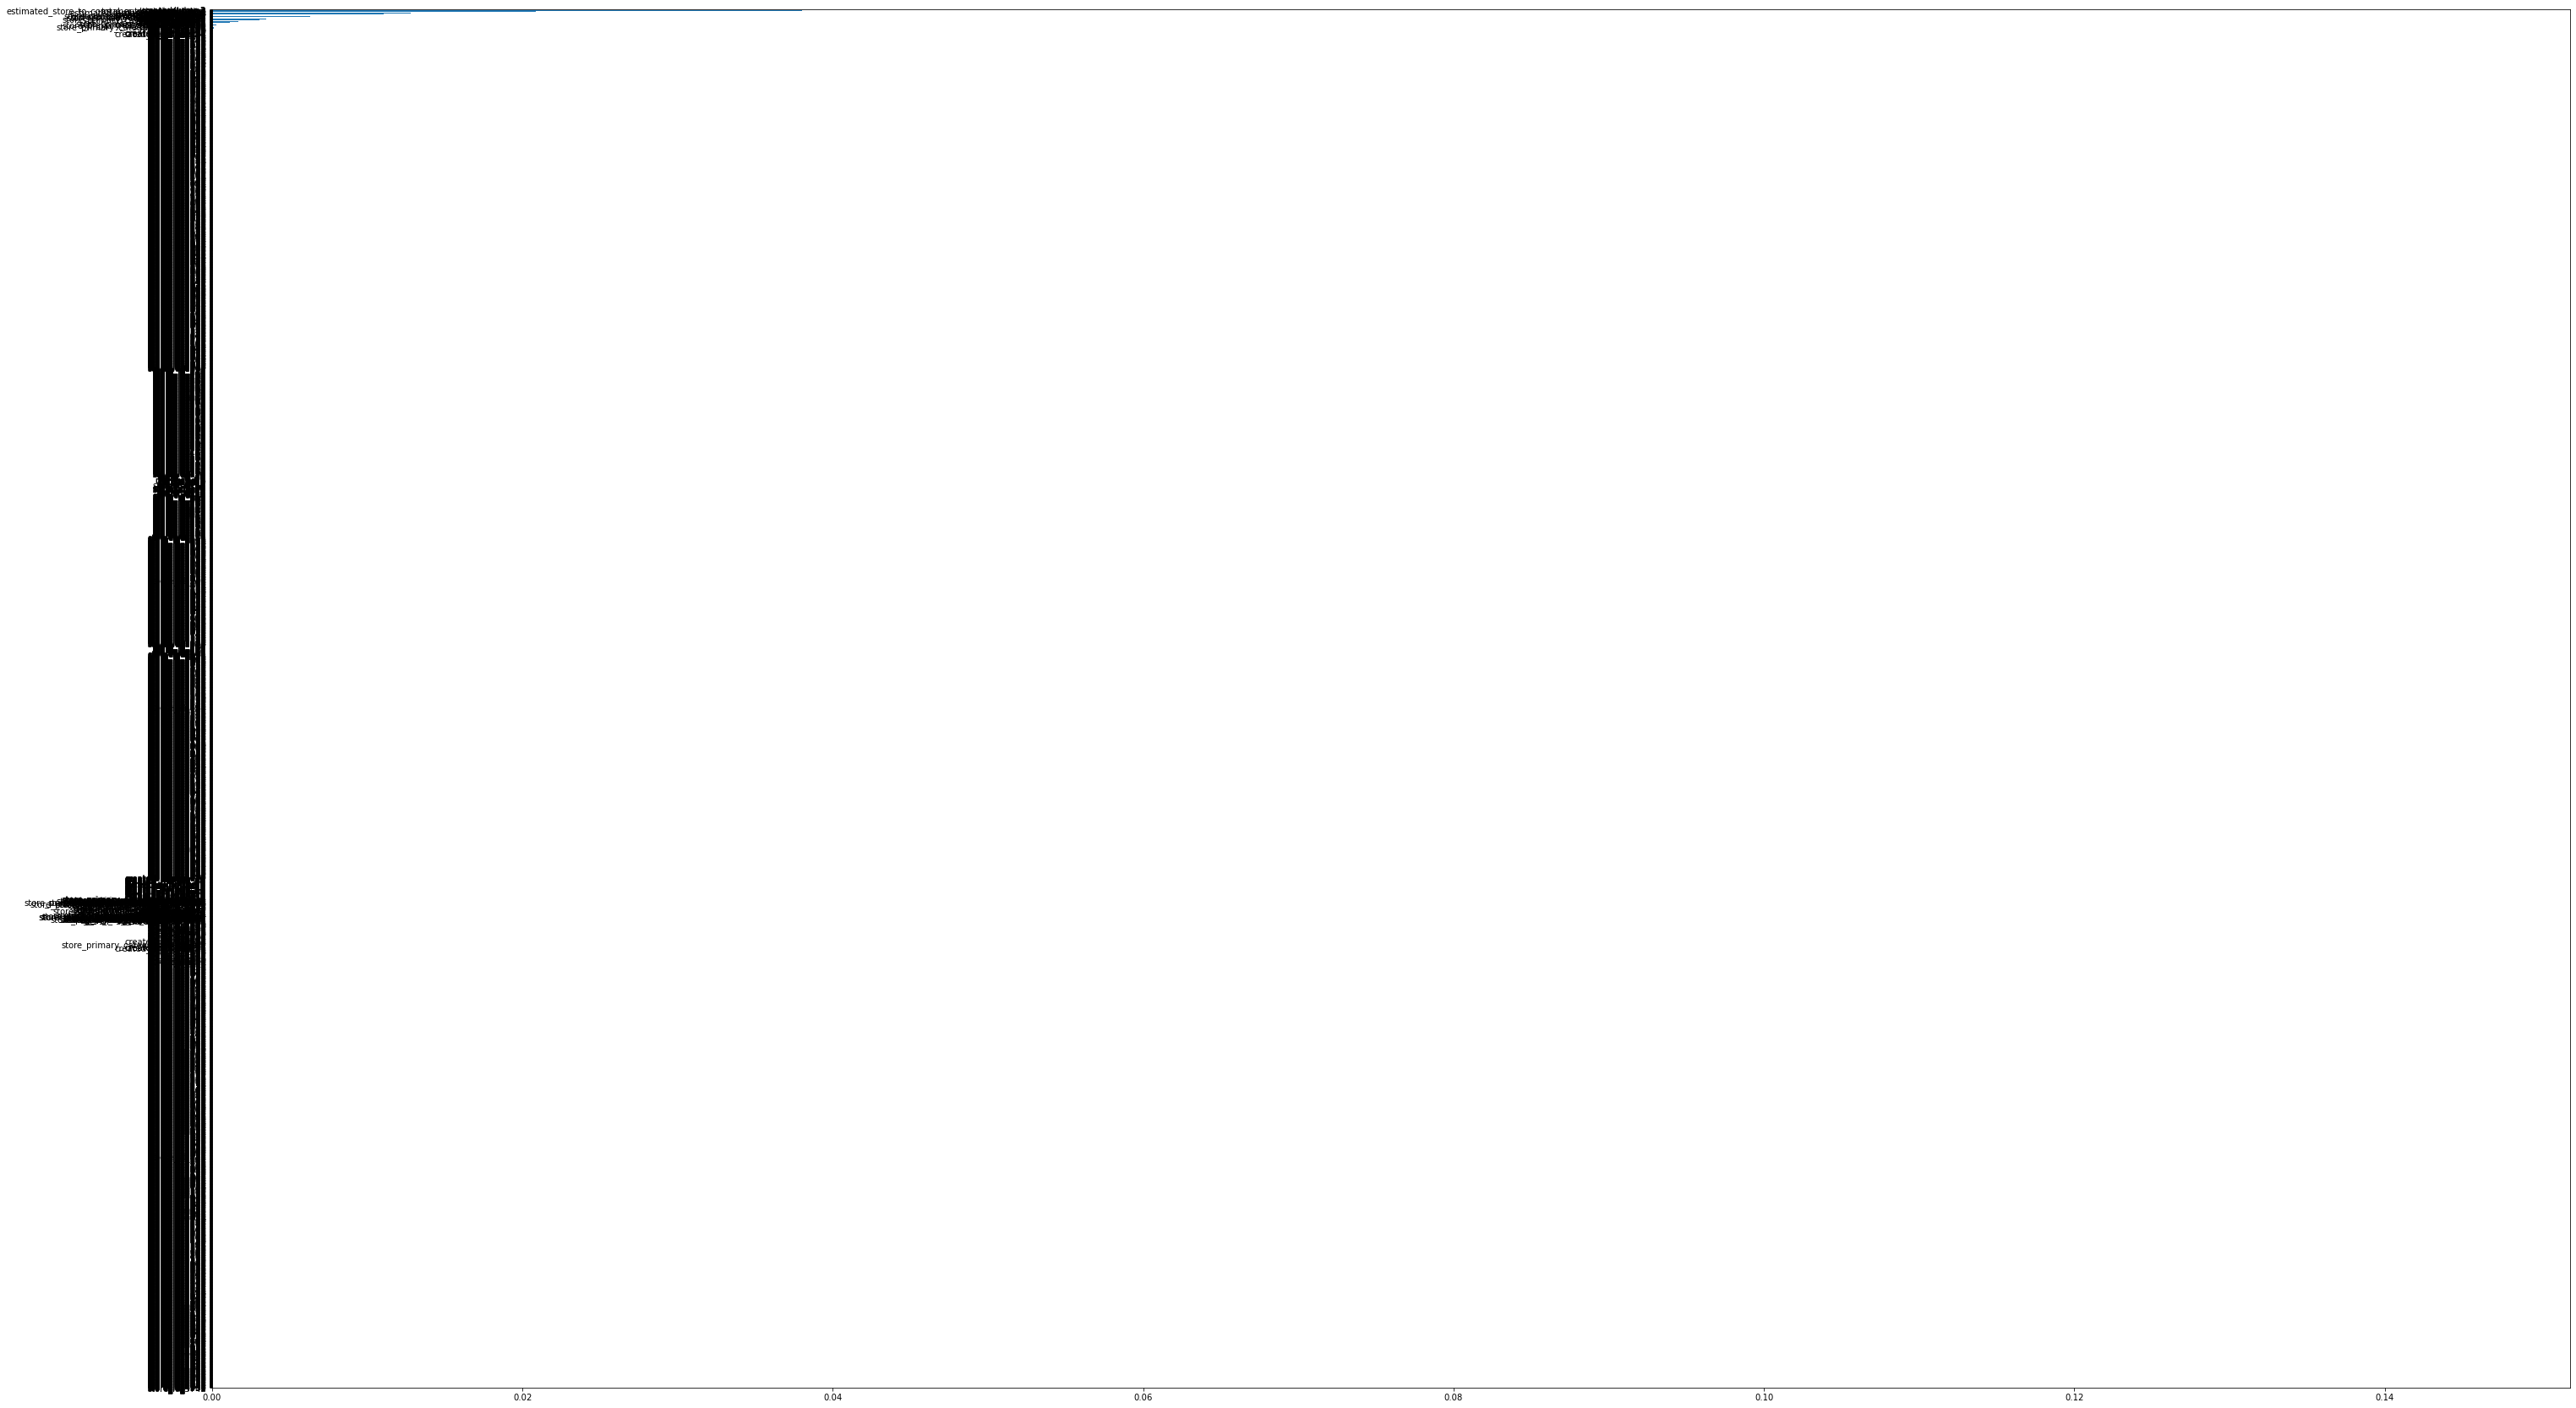

In [992]:
plt.figure(figsize = (50, 30))
Series_feat_imp = pd.Series(feature_importance, index = xtrain.columns)
Series_feat_imp.sort_values(ascending = True).plot.barh()
plt.show()

읽을 수 없는 그래프(칼럼이 너무 많기 때문)<br>
그러나 한 가지 확인할 수 있는 사실은 아래에서부터 오름차순으로 정렬을 했기 때문에 아래에서부터 위로 가면서 그래프가 보여야하나<br>
대부분의 그래프가 보이지않는 것으로 보아 예측에 유용한 칼럼들은 적다는 것을 알 수 있음

In [1143]:
# 유용한 feature들만 추출
useful_feature = xtrain.columns[feature_importance > 0.003]
print(useful_feature)
useful_feature1 = xtrain.columns[feature_importance > 0.01]
print(useful_feature1)

Index(['total_items', 'subtotal', 'num_distinct_items', 'max_item_price',
       'total_onshift', 'total_busy', 'total_outstanding_orders',
       'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'market_id_1',
       'market_id_2', 'market_id_3', 'market_id_4', 'store_id_326',
       'store_id_400', 'store_id_415', 'store_id_591', 'store_id_1246',
       'store_id_1378', 'store_id_1381', 'store_id_1858', 'store_id_1997',
       'store_id_2090', 'store_id_3438', 'store_id_3763', 'store_id_3937',
       'store_id_4301', 'store_id_4367', 'store_id_4964', 'store_id_4998',
       'store_id_5815', 'store_id_6281', 'store_id_6754', 'store_id_6865',
       'store_id_6889', 'store_primary_category_dessert',
       'store_primary_category_japanese', 'store_primary_category_mexican',
       'store_primary_category_pizza', 'store_primary_category_salad',
       'store_primary_category_sandwich', 'order_protocol_1',
       'order_protocol_3', 'order_protocol

In [1279]:
model = XGBRegressor(n_estimators = 400, **params)
model.fit(xtrain[useful_feature], ytrain) #0.3 * np.mean(ytrain))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.317059526277918,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.015539646444904177,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=400, n_jobs=10,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=1.1389029604843652e-05, reg_lambda=9.817955290566974e-05,
             scale_pos_weight=1, subsample=0.7016866231737348,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [1280]:
preds_valid = model.predict(xvalid[useful_feature])

In [1281]:
preds_valid

array([2759.3677, 3675.9387, 2599.715 , ..., 2578.6477, 3216.839 ,
       2122.516 ], dtype=float32)

In [1282]:
mse = mean_squared_error(yvalid, preds_valid)
rmse = np.sqrt(mse)
rmse

876.2414405428246

---

### 최적의 하이퍼 파라미터 구하기

In [1187]:
def run(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 7)

    model = XGBRegressor(
        random_state=42,
        n_estimators=7000,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
    )
    model.fit(xtrain[useful_feature], ytrain, early_stopping_rounds=300, eval_set=[(xvalid[useful_feature], yvalid)], verbose=1000)
    preds_valid = model.predict(xvalid[useful_feature])
    rmse = mean_squared_error(yvalid, preds_valid, squared=False)
    return rmse

In [1188]:
study = optuna.create_study(direction = "minimize")
study.optimize(run, n_trials=20)

[I 2022-01-24 16:26:30,618] A new study created in memory with name: no-name-3cd4012f-4924-4b8b-bd11-aaa626397d4a


[0]	validation_0-rmse:2963.07080
[1000]	validation_0-rmse:847.90497
[2000]	validation_0-rmse:843.31525
[3000]	validation_0-rmse:842.75476
[3131]	validation_0-rmse:842.70868


[I 2022-01-24 16:30:29,127] Trial 0 finished with value: 842.6596859033679 and parameters: {'learning_rate': 0.030172093377734414, 'reg_lambda': 57.18462748556254, 'reg_alpha': 0.00010059503269010995, 'subsample': 0.4236551328134973, 'colsample_bytree': 0.7872737214503935, 'max_depth': 6}. Best is trial 0 with value: 842.6596859033679.


[0]	validation_0-rmse:3010.16821
[1000]	validation_0-rmse:862.76556
[2000]	validation_0-rmse:849.87640
[3000]	validation_0-rmse:846.12634
[4000]	validation_0-rmse:844.17255
[5000]	validation_0-rmse:843.32221
[6000]	validation_0-rmse:842.66290
[6999]	validation_0-rmse:842.33502


[I 2022-01-24 16:36:44,755] Trial 1 finished with value: 842.3245005162735 and parameters: {'learning_rate': 0.012426344034948834, 'reg_lambda': 0.09316258876251138, 'reg_alpha': 1.6629431512601369e-06, 'subsample': 0.3541903573999744, 'colsample_bytree': 0.6526827257385519, 'max_depth': 5}. Best is trial 1 with value: 842.3245005162735.


[0]	validation_0-rmse:2688.93530
[1000]	validation_0-rmse:859.56934
[1326]	validation_0-rmse:860.76959


[I 2022-01-24 16:37:20,501] Trial 2 finished with value: 859.4821679546037 and parameters: {'learning_rate': 0.13313950722804554, 'reg_lambda': 1.8390293973992144e-07, 'reg_alpha': 6.310830713605536e-07, 'subsample': 0.16385576933955115, 'colsample_bytree': 0.15763843304665645, 'max_depth': 4}. Best is trial 1 with value: 842.3245005162735.


[0]	validation_0-rmse:3008.91602
[1000]	validation_0-rmse:963.73376
[2000]	validation_0-rmse:942.54535
[3000]	validation_0-rmse:931.10059
[4000]	validation_0-rmse:922.73889
[5000]	validation_0-rmse:916.03418
[6000]	validation_0-rmse:910.60370
[6999]	validation_0-rmse:906.12274


[I 2022-01-24 16:39:33,938] Trial 3 finished with value: 906.1227736894166 and parameters: {'learning_rate': 0.013106077295216463, 'reg_lambda': 0.0003365446466469822, 'reg_alpha': 1.0127264919398716e-05, 'subsample': 0.9993901796306244, 'colsample_bytree': 0.8856674784615918, 'max_depth': 1}. Best is trial 1 with value: 842.3245005162735.


[0]	validation_0-rmse:3015.87573
[1000]	validation_0-rmse:903.92932
[2000]	validation_0-rmse:880.69684
[3000]	validation_0-rmse:870.60492
[4000]	validation_0-rmse:864.08649
[5000]	validation_0-rmse:858.95520
[6000]	validation_0-rmse:855.54462
[6999]	validation_0-rmse:853.02789


[I 2022-01-24 16:43:24,148] Trial 4 finished with value: 853.0252953741676 and parameters: {'learning_rate': 0.010476860680196915, 'reg_lambda': 1.2914068958202922, 'reg_alpha': 1.5557552427250852e-05, 'subsample': 0.4635424386417397, 'colsample_bytree': 0.16778600819286663, 'max_depth': 4}. Best is trial 1 with value: 842.3245005162735.


[0]	validation_0-rmse:2920.64282
[1000]	validation_0-rmse:873.06616
[2000]	validation_0-rmse:862.69098
[3000]	validation_0-rmse:859.85284
[4000]	validation_0-rmse:857.68646
[5000]	validation_0-rmse:856.63629
[6000]	validation_0-rmse:855.36249
[6999]	validation_0-rmse:854.51038


[I 2022-01-24 16:46:49,051] Trial 5 finished with value: 854.481735384662 and parameters: {'learning_rate': 0.04588786798159648, 'reg_lambda': 1.0781892332042933e-08, 'reg_alpha': 0.008027620896440992, 'subsample': 0.3964957665973883, 'colsample_bytree': 0.7782450782757286, 'max_depth': 2}. Best is trial 1 with value: 842.3245005162735.


[0]	validation_0-rmse:2944.58936
[1000]	validation_0-rmse:863.65112
[2000]	validation_0-rmse:854.00897
[3000]	validation_0-rmse:850.97040
[4000]	validation_0-rmse:848.82398
[5000]	validation_0-rmse:847.37830
[6000]	validation_0-rmse:846.48993
[6999]	validation_0-rmse:846.15765


[I 2022-01-24 16:50:46,075] Trial 6 finished with value: 846.1521589151345 and parameters: {'learning_rate': 0.03692815035873926, 'reg_lambda': 4.641961051296409e-07, 'reg_alpha': 22.40997031500773, 'subsample': 0.7315931094945992, 'colsample_bytree': 0.4834176606853915, 'max_depth': 3}. Best is trial 1 with value: 842.3245005162735.


[0]	validation_0-rmse:2972.80518
[1000]	validation_0-rmse:893.82483
[2000]	validation_0-rmse:872.09436
[3000]	validation_0-rmse:865.26276
[4000]	validation_0-rmse:861.95727
[5000]	validation_0-rmse:859.86365
[6000]	validation_0-rmse:858.62305
[6999]	validation_0-rmse:857.48401


[I 2022-01-24 16:53:57,837] Trial 7 finished with value: 857.4842603792811 and parameters: {'learning_rate': 0.02650263693561861, 'reg_lambda': 6.591318231143683, 'reg_alpha': 0.027391083153517196, 'subsample': 0.755737500447372, 'colsample_bytree': 0.6367405182600641, 'max_depth': 2}. Best is trial 1 with value: 842.3245005162735.


[0]	validation_0-rmse:2922.26636
[1000]	validation_0-rmse:851.94214
[2000]	validation_0-rmse:845.89056
[3000]	validation_0-rmse:843.70801
[4000]	validation_0-rmse:842.77734
[4747]	validation_0-rmse:842.52905


[I 2022-01-24 16:56:53,864] Trial 8 finished with value: 842.4595341489418 and parameters: {'learning_rate': 0.04520641413715504, 'reg_lambda': 0.00533761568322056, 'reg_alpha': 0.0548837313619163, 'subsample': 0.8317527557433508, 'colsample_bytree': 0.3382521900833367, 'max_depth': 4}. Best is trial 1 with value: 842.3245005162735.


[0]	validation_0-rmse:2836.78735
[1000]	validation_0-rmse:844.52411
[1508]	validation_0-rmse:844.93756


[I 2022-01-24 16:58:38,318] Trial 9 finished with value: 844.2346813623448 and parameters: {'learning_rate': 0.07637965994222602, 'reg_lambda': 0.0041130498988861, 'reg_alpha': 0.0030427586382325636, 'subsample': 0.549689451770158, 'colsample_bytree': 0.7003040791235835, 'max_depth': 5}. Best is trial 1 with value: 842.3245005162735.


[0]	validation_0-rmse:2995.34888
[1000]	validation_0-rmse:851.11102
[2000]	validation_0-rmse:849.82599
[2460]	validation_0-rmse:849.90503


[I 2022-01-24 17:01:14,640] Trial 10 finished with value: 849.6267003491204 and parameters: {'learning_rate': 0.017806861971237133, 'reg_lambda': 0.17498543568920866, 'reg_alpha': 6.248828054160498e-08, 'subsample': 0.1149323437081792, 'colsample_bytree': 0.9827095293919226, 'max_depth': 7}. Best is trial 1 with value: 842.3245005162735.


[0]	validation_0-rmse:2445.92041
[684]	validation_0-rmse:849.19818


[I 2022-01-24 17:01:47,923] Trial 11 finished with value: 847.0733191628005 and parameters: {'learning_rate': 0.22339975117595495, 'reg_lambda': 0.002648002316046868, 'reg_alpha': 2.179082866945982, 'subsample': 0.9371689325132294, 'colsample_bytree': 0.4146176299487565, 'max_depth': 5}. Best is trial 1 with value: 842.3245005162735.


[0]	validation_0-rmse:2805.39331
[1000]	validation_0-rmse:850.12335
[1174]	validation_0-rmse:850.10675


[I 2022-01-24 17:02:34,823] Trial 12 finished with value: 849.3098431576306 and parameters: {'learning_rate': 0.08857418627919157, 'reg_lambda': 0.00010993013407811904, 'reg_alpha': 0.5650116786525105, 'subsample': 0.2927721465892864, 'colsample_bytree': 0.3384433416647547, 'max_depth': 5}. Best is trial 1 with value: 842.3245005162735.


[0]	validation_0-rmse:2986.92358
[1000]	validation_0-rmse:845.68304
[2000]	validation_0-rmse:839.85913
[3000]	validation_0-rmse:838.37848
[4000]	validation_0-rmse:838.21765
[4098]	validation_0-rmse:838.27606


[I 2022-01-24 17:06:55,333] Trial 13 finished with value: 838.1485399788241 and parameters: {'learning_rate': 0.021071886520910913, 'reg_lambda': 0.040876701854063675, 'reg_alpha': 1.9873731204143632e-08, 'subsample': 0.6767966935827463, 'colsample_bytree': 0.31447543411072, 'max_depth': 7}. Best is trial 13 with value: 838.1485399788241.


[0]	validation_0-rmse:2992.77832
[1000]	validation_0-rmse:844.62305
[2000]	validation_0-rmse:841.20001
[3000]	validation_0-rmse:840.81012
[3033]	validation_0-rmse:840.83716


[I 2022-01-24 17:11:17,180] Trial 14 finished with value: 840.7531652500463 and parameters: {'learning_rate': 0.01876004850394189, 'reg_lambda': 0.11043301137067937, 'reg_alpha': 1.4715504907663456e-08, 'subsample': 0.6410281736329714, 'colsample_bytree': 0.5982882612092281, 'max_depth': 7}. Best is trial 13 with value: 838.1485399788241.


[0]	validation_0-rmse:2988.03052
[1000]	validation_0-rmse:844.02978
[2000]	validation_0-rmse:840.36444
[3000]	validation_0-rmse:839.92169
[3013]	validation_0-rmse:839.91656


[I 2022-01-24 17:15:16,947] Trial 15 finished with value: 839.8458300294707 and parameters: {'learning_rate': 0.020574730599983597, 'reg_lambda': 2.1127027826201144e-05, 'reg_alpha': 2.4664198220884357e-08, 'subsample': 0.6255448926334485, 'colsample_bytree': 0.49987721380073946, 'max_depth': 7}. Best is trial 13 with value: 838.1485399788241.


[0]	validation_0-rmse:2979.49609
[1000]	validation_0-rmse:846.57068
[2000]	validation_0-rmse:840.89026
[3000]	validation_0-rmse:839.86774
[3604]	validation_0-rmse:839.72388


[I 2022-01-24 17:19:05,826] Trial 16 finished with value: 839.66289840487 and parameters: {'learning_rate': 0.023799884475761923, 'reg_lambda': 1.4224303788085761e-05, 'reg_alpha': 1.741173590670879e-07, 'subsample': 0.5856447854556857, 'colsample_bytree': 0.2741857911077426, 'max_depth': 7}. Best is trial 13 with value: 838.1485399788241.


[0]	validation_0-rmse:2875.96729
[1000]	validation_0-rmse:845.50653
[1937]	validation_0-rmse:843.75891


[I 2022-01-24 17:20:39,601] Trial 17 finished with value: 843.6630633850556 and parameters: {'learning_rate': 0.06249888629693666, 'reg_lambda': 7.990554452952375e-06, 'reg_alpha': 3.322147186182665e-07, 'subsample': 0.5712363918209885, 'colsample_bytree': 0.21328059123331938, 'max_depth': 6}. Best is trial 13 with value: 838.1485399788241.


[0]	validation_0-rmse:2975.54541
[1000]	validation_0-rmse:849.46020
[2000]	validation_0-rmse:842.05573
[3000]	validation_0-rmse:840.10437
[4000]	validation_0-rmse:839.75800
[4445]	validation_0-rmse:839.73041


[I 2022-01-24 17:24:32,333] Trial 18 finished with value: 839.6907590903916 and parameters: {'learning_rate': 0.025312510224889475, 'reg_lambda': 2.406154313604334e-06, 'reg_alpha': 0.0002824828467341782, 'subsample': 0.8374113575218434, 'colsample_bytree': 0.26236743490871833, 'max_depth': 6}. Best is trial 13 with value: 838.1485399788241.


[0]	validation_0-rmse:3001.90674
[1000]	validation_0-rmse:849.88605
[2000]	validation_0-rmse:841.86621
[3000]	validation_0-rmse:839.49786
[4000]	validation_0-rmse:838.50372
[5000]	validation_0-rmse:838.02545
[5503]	validation_0-rmse:838.12933


[I 2022-01-24 17:30:20,601] Trial 19 finished with value: 837.9899035323243 and parameters: {'learning_rate': 0.015539646444904177, 'reg_lambda': 9.817955290566974e-05, 'reg_alpha': 1.1389029604843652e-05, 'subsample': 0.7016866231737348, 'colsample_bytree': 0.317059526277918, 'max_depth': 7}. Best is trial 19 with value: 837.9899035323243.


In [1189]:
# 최적의 하이퍼 파라미터
study.best_params

{'learning_rate': 0.015539646444904177,
 'reg_lambda': 9.817955290566974e-05,
 'reg_alpha': 1.1389029604843652e-05,
 'subsample': 0.7016866231737348,
 'colsample_bytree': 0.317059526277918,
 'max_depth': 7}

In [1190]:
params = {'learning_rate': 0.015539646444904177,
          'reg_lambda': 9.817955290566974e-05,
          'reg_alpha': 1.1389029604843652e-05,
          'subsample': 0.7016866231737348,
          'colsample_bytree': 0.317059526277918,
          'max_depth': 7}
model = XGBRegressor(n_estimators = 3000, **params)

In [1270]:
model = XGBRegressor(n_estimators = 3000, **params)
model.fit(xtrain[useful_feature], ytrain)
preds_valid = model.predict(xvalid[useful_feature])

In [1271]:
preds_valid

array([2647.6758, 3659.7087, 2210.0376, ..., 2410.4705, 3223.05  ,
       2026.147 ], dtype=float32)

In [1272]:
# 검증데이터 rmse
mse = mean_squared_error(yvalid, preds_valid)
rmse = np.sqrt(mse)
rmse

839.9647601339018

In [1273]:
preds_test = model.predict(xtest[useful_feature])

In [1274]:
# 테스트데이터 rmse
mse = mean_squared_error(ytest, preds_test)
rmse = np.sqrt(mse)
print(f'{rmse:.2f}(s)')

837.12(s)


In [1275]:
# underpredict 비율
u_p = (ytest - preds_test > 0).sum() / len(ytest) * 100
print(f'{u_p:.2f}(%)')

43.29(%)


underpredict를 줄이려면 모델이 조금 더 큰 값을 예측하도록 해야함<br>
모델 훈련 간 ytrain의 값을 조금 높여서 모델을 훈련시켜 underpredict를 방지<br>
<br>
그러나 너무 높게 ytrain을 설정하면 모델의 rmse값이 커지게 되므로 trade-off를 하여 적절한 수준 ytrain 설정필요

In [1278]:
weights = [x / 100 for x in range(105, 155, 5)]

for w in weights:
    print(f'가중치: {w}')
    model.fit(xtrain[useful_feature], ytrain * w)
    preds_valid = model.predict(xvalid[useful_feature])
    
    val_mse = mean_squared_error(yvalid, preds_valid)
    val_rmse = np.sqrt(val_mse)
    
    preds_test = model.predict(xtest[useful_feature])
    test_mse = mean_squared_error(ytest, preds_test)
    test_rmse = np.sqrt(test_mse)
    
    print(f'검증 데이터 rmse: {val_rmse:.2f}(s)')
    print(f'테스트 데이터 rmse: {test_rmse:.2f}(s)')
    
    under_pred_rate = (ytest - preds_test > 0).sum() / len(ytest) * 100
    print(f'underprediction rate: {under_pred_rate:.2f}(%)')
    print()
    print()

가중치: 1.05
검증 데이터 rmse: 852.68(s)
테스트 데이터 rmse: 849.67(s)
underprediction rate: 36.01(%)


가중치: 1.1
검증 데이터 rmse: 889.71(s)
테스트 데이터 rmse: 886.28(s)
underprediction rate: 29.51(%)


가중치: 1.15
검증 데이터 rmse: 947.94(s)
테스트 데이터 rmse: 943.93(s)
underprediction rate: 24.07(%)


가중치: 1.2
검증 데이터 rmse: 1023.99(s)
테스트 데이터 rmse: 1019.94(s)
underprediction rate: 19.66(%)


가중치: 1.25
검증 데이터 rmse: 1114.05(s)
테스트 데이터 rmse: 1110.04(s)
underprediction rate: 15.85(%)


가중치: 1.3
검증 데이터 rmse: 1215.39(s)
테스트 데이터 rmse: 1211.26(s)
underprediction rate: 12.74(%)


가중치: 1.35
검증 데이터 rmse: 1324.57(s)
테스트 데이터 rmse: 1320.97(s)
underprediction rate: 10.21(%)


가중치: 1.4
검증 데이터 rmse: 1440.84(s)
테스트 데이터 rmse: 1438.30(s)
underprediction rate: 8.22(%)


가중치: 1.45
검증 데이터 rmse: 1562.13(s)
테스트 데이터 rmse: 1559.56(s)
underprediction rate: 6.63(%)


가중치: 1.5
검증 데이터 rmse: 1687.50(s)
테스트 데이터 rmse: 1684.18(s)
underprediction rate: 5.20(%)




underprediction에 겪는 불편함이 overprediction에 두 배라는 점을 감안한다면<br>
underprediction의 비율이 overprediction보다 두 배 적을 때가 가장 좋다고 판단<br>
<br>
따라서 가중치가 1.1일 때 가장 이상적인 예측이 이루어진다고 볼 수 있다<br>
이에 따른 손실함수는 다음과 같다<br>
<br>
$ \displaystyle \mbox{RMSE} = \frac{1}{2} \sqrt{\sum_i \left( y_{i_{pred}} - wy_i \right)^2} $